# Cálculo de la frecuencia cardiaca a partir del artículo ["How to Design Peripheral Oxygen Saturation (SpO2) and Optical Heart Rate Monitoring (OHRM) Systems Using the AFE4403"](https://www.ti.com/lit/an/slaa655/slaa655.pdf)

**Referencia:**Texas Instruments. (2014). How to design peripheral oxygen saturation (SpO₂) and optical heart rate monitoring (OHRM) systems using the AFE4403 (Application Report SLAA655).

Puntos clave que explica este artículo para la extracción de la frecuencia cardíaca a partir de los datos del pulsioxímetro:

### Adquisición de la señal PPG:

- Explica cómo la luz de los LEDs (rojo e infrarrojo) interactúa con los tejidos y la sangre.

- Menciona que el componente pulsátil de la señal (AC) representa la absorción en la sangre arterial, mientras que el componente DC proviene de otros tejidos.

- La periodicidad de la señal PPG está directamente relacionada con la frecuencia cardíaca.

### Impacto de la ganancia y la corriente LED:

- El documento habla sobre cómo la señal se ve afectada por los ajustes del AFE4403, lo que puede ser útil para interpretar los datos crudos.

- Aumentar la corriente del LED aumenta la señal DC, pero demasiado puede saturarla.

- La ganancia del amplificador de transimpedancia (TIA) también influye en la calidad de la señal.

### Postprocesamiento para extracción de la frecuencia cardíaca:

- Sugiere aplicar filtros para eliminar el ruido de la red eléctrica (60 Hz) y artefactos de movimiento.

- Se puede calcular la frecuencia cardíaca midiendo la separación entre los picos sucesivos de la señal PPG.

- Si hay artefactos de movimiento, se recomienda usar algoritmos de cancelación de ruido (por ejemplo, basados en acelerómetros).

## Posibles acciones a tomar:
- Filtrado: Asegurar que aplica un filtrado adecuado, como un paso banda centrado en la frecuencia cardíaca esperada (~0.5 - 3 Hz).

- Detección de picos:probar diferentes métodos para detectar los picos en la señal PPG, como derivadas o transformada de wavelet.

- Corrección de la señal DC: Si la señal tiene cambios bruscos de DC (por movimiento o variaciones en el sensor),  probar algoritmos de normalización o filtrado adaptativo.

## 1. Filtro Butterworth
El filtro Butterworth es un filtro paso banda, diseñado para pasar las frecuencias de interés (en este caso, la frecuencia cardíaca) y atenuar las frecuencias fuera de ese rango. Se usa para eliminar componentes de baja y alta frecuencia que no son útiles para la estimación de la frecuencia cardíaca, como las fluctuaciones debidas a la respiración o el movimiento.

El artículo menciona la importancia de filtrar el ruido y eliminación de la deriva en la señal. En este contexto, un filtro paso banda como el Butterworth es útil para eliminar interferencias como el ruido de línea de 60 Hz y las variaciones del DC.


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks
import numpy as np

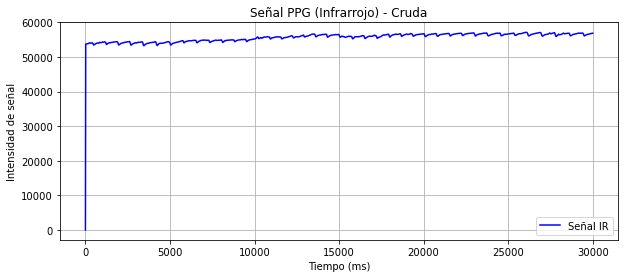

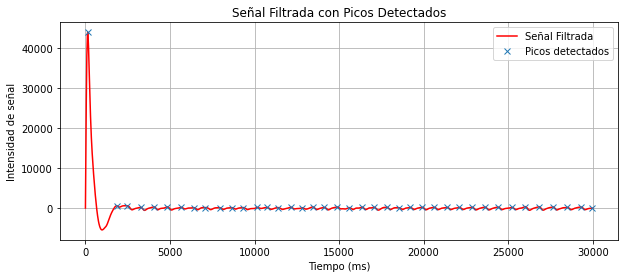

Frecuencia cardíaca estimada: 78.49 bpm


In [3]:
# 1. Cargar los datos
file_path = file_path = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\save_log2\raw_data_95_77_2.csv"
df = pd.read_csv(file_path)

# 2. Visualizar la señal PPG (IR)
plt.figure(figsize=(10, 4))
plt.plot(df["Tiempo (ms)"], df["IR"], label="Señal IR", color="blue")
plt.xlabel("Tiempo (ms)")
plt.ylabel("Intensidad de señal")
plt.title("Señal PPG (Infrarrojo) - Cruda")
plt.legend()
plt.grid(True)
plt.show()

# 3. Filtrar la señal (Paso banda 0.5 - 3 Hz)
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut=0.5, highcut=3.0, fs=60, order=2):
    b, a = butter_bandpass(lowcut, highcut, fs, order)
    return filtfilt(b, a, data)

fs = 1000 / (df["Tiempo (ms)"].diff().mean())  # Calcular frecuencia de muestreo
df["IR_filtrada"] = bandpass_filter(df["IR"], fs=fs)

# 4. Detectar picos para calcular la frecuencia cardíaca
peaks, _ = find_peaks(df["IR_filtrada"], distance=fs/2)  # Separación mínima de 0.5s (~30 latidos/min)

# Graficar señal filtrada y picos detectados
plt.figure(figsize=(10, 4))
plt.plot(df["Tiempo (ms)"], df["IR_filtrada"], label="Señal Filtrada", color="red")
plt.plot(df["Tiempo (ms)"].iloc[peaks], df["IR_filtrada"].iloc[peaks], "x", label="Picos detectados")
plt.xlabel("Tiempo (ms)")
plt.ylabel("Intensidad de señal")
plt.title("Señal Filtrada con Picos Detectados")
plt.legend()
plt.grid(True)
plt.show()

# 5. Calcular frecuencia cardíaca
rr_intervals = df["Tiempo (ms)"].iloc[peaks].diff().dropna()  # Diferencias entre picos
global_hr = 60000 / rr_intervals.mean()  # Convertir a latidos por minuto (bpm)
print(f"Frecuencia cardíaca estimada: {global_hr:.2f} bpm")

Para una frecuencia esperada (medida con el pulsioxímetro comercial) de 77 BPM, se estima una frecuencia cardiaca de 78,49 BPM, que está bastante bien teniendo en cuenta que hay un artefacto de movimiento muy grande al inicio del registro (debido a ese microsegundo en el que se coloca el sensor). También es verdad que al estar midiendo el parámetro en reposo, la señal es bastante buena y se detectan los picos con mucha claridad. Si recortamos los primeros segundos, igual que se puede obtener una frecuencia cardiaca más cercana al valor de referencia.

**Recorte solo del principio**

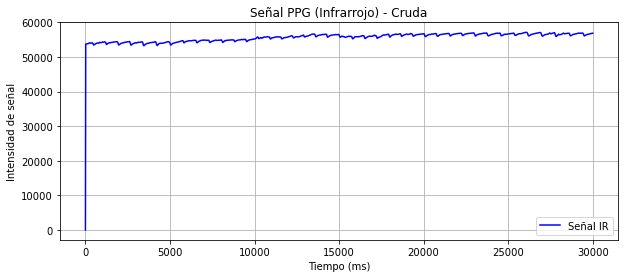

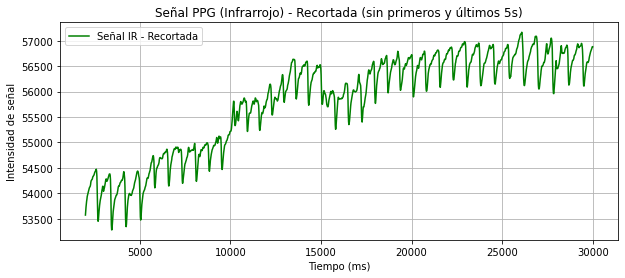

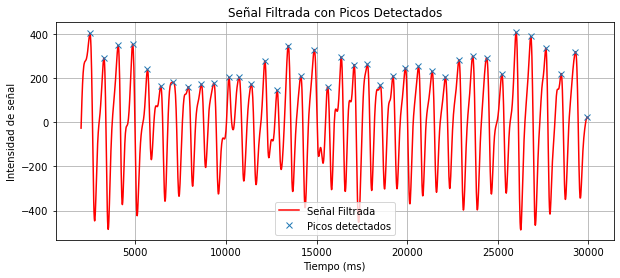

Frecuencia cardíaca estimada: 80.83 bpm


In [7]:
# Visualizar la señal PPG (IR)
plt.figure(figsize=(10, 4))
plt.plot(df["Tiempo (ms)"], df["IR"], label="Señal IR", color="blue")
plt.xlabel("Tiempo (ms)")
plt.ylabel("Intensidad de señal")
plt.title("Señal PPG (Infrarrojo) - Cruda")
plt.legend()
plt.grid(True)
plt.show()

# Obtener el tiempo inicial y final
t_inicio = df["Tiempo (ms)"].iloc[0] + 2000  # +2 segundos
df_recortado = df[(df["Tiempo (ms)"] >= t_inicio)].reset_index(drop=True)

# Visualizar la señal recortada
plt.figure(figsize=(10, 4))
plt.plot(df_recortado["Tiempo (ms)"], df_recortado["IR"], label="Señal IR - Recortada", color="green")
plt.xlabel("Tiempo (ms)")
plt.ylabel("Intensidad de señal")
plt.title("Señal PPG (Infrarrojo) - Recortada (sin primeros y últimos 5s)")
plt.legend()
plt.grid(True)
plt.show()

# Filtrar la señal (Paso banda 0.5 - 3 Hz)
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut=0.5, highcut=3.0, fs=60, order=2):
    b, a = butter_bandpass(lowcut, highcut, fs, order)
    return filtfilt(b, a, data)

fs = 1000 / (df_recortado["Tiempo (ms)"].diff().mean())  # Calcular frecuencia de muestreo
df_recortado["IR_filtrada"] = bandpass_filter(df_recortado["IR"], fs=fs)

# Detectar picos para calcular la frecuencia cardíaca
peaks, _ = find_peaks(df_recortado["IR_filtrada"], distance=fs/2)  # Separación mínima de 0.5s (~30 latidos/min)

# Graficar señal filtrada y picos detectados
plt.figure(figsize=(10, 4))
plt.plot(df_recortado["Tiempo (ms)"], df_recortado["IR_filtrada"], label="Señal Filtrada", color="red")
plt.plot(df_recortado["Tiempo (ms)"].iloc[peaks], df_recortado["IR_filtrada"].iloc[peaks], "x", label="Picos detectados")
plt.xlabel("Tiempo (ms)")
plt.ylabel("Intensidad de señal")
plt.title("Señal Filtrada con Picos Detectados")
plt.legend()
plt.grid(True)
plt.show()

# Calcular frecuencia cardíaca
rr_intervals = df_recortado["Tiempo (ms)"].iloc[peaks].diff().dropna()  # Diferencias entre picos
global_hr = 60000 / rr_intervals.mean()  # Convertir a latidos por minuto (bpm)
print(f"Frecuencia cardíaca estimada: {global_hr:.2f} bpm")


**Recorte de principio y fin**

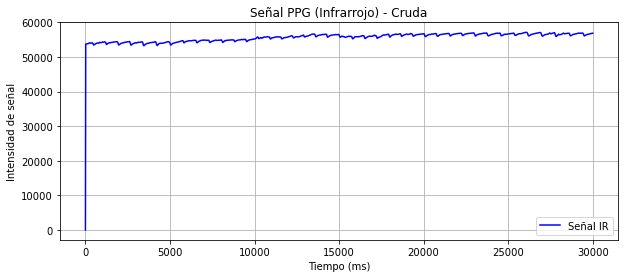

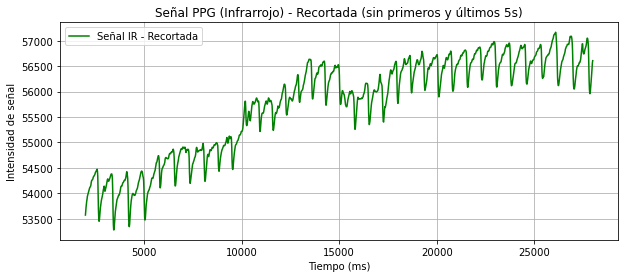

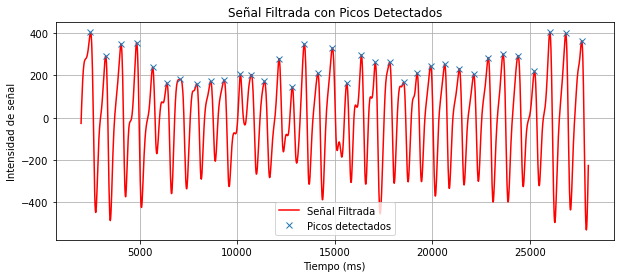

Frecuencia cardíaca estimada: 81.06 bpm


In [9]:
# Visualizar la señal PPG (IR)
plt.figure(figsize=(10, 4))
plt.plot(df["Tiempo (ms)"], df["IR"], label="Señal IR", color="blue")
plt.xlabel("Tiempo (ms)")
plt.ylabel("Intensidad de señal")
plt.title("Señal PPG (Infrarrojo) - Cruda")
plt.legend()
plt.grid(True)
plt.show()


df_recortado = df[(df["Tiempo (ms)"] >= t_inicio) & (df["Tiempo (ms)"] <= t_final)].reset_index(drop=True)

# Visualizar la señal recortada
plt.figure(figsize=(10, 4))
plt.plot(df_recortado["Tiempo (ms)"], df_recortado["IR"], label="Señal IR - Recortada", color="green")
plt.xlabel("Tiempo (ms)")
plt.ylabel("Intensidad de señal")
plt.title("Señal PPG (Infrarrojo) - Recortada (sin primeros y últimos 5s)")
plt.legend()
plt.grid(True)
plt.show()

# Filtrar la señal (Paso banda 0.5 - 3 Hz)
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut=0.5, highcut=3.0, fs=60, order=2):
    b, a = butter_bandpass(lowcut, highcut, fs, order)
    return filtfilt(b, a, data)

fs = 1000 / (df_recortado["Tiempo (ms)"].diff().mean())  # Calcular frecuencia de muestreo
df_recortado["IR_filtrada"] = bandpass_filter(df_recortado["IR"], fs=fs)

# Detectar picos para calcular la frecuencia cardíaca
peaks, _ = find_peaks(df_recortado["IR_filtrada"], distance=fs/2)  # Separación mínima de 0.5s (~30 latidos/min)

# Graficar señal filtrada y picos detectados
plt.figure(figsize=(10, 4))
plt.plot(df_recortado["Tiempo (ms)"], df_recortado["IR_filtrada"], label="Señal Filtrada", color="red")
plt.plot(df_recortado["Tiempo (ms)"].iloc[peaks], df_recortado["IR_filtrada"].iloc[peaks], "x", label="Picos detectados")
plt.xlabel("Tiempo (ms)")
plt.ylabel("Intensidad de señal")
plt.title("Señal Filtrada con Picos Detectados")
plt.legend()
plt.grid(True)
plt.show()

# Calcular frecuencia cardíaca
rr_intervals = df_recortado["Tiempo (ms)"].iloc[peaks].diff().dropna()  # Diferencias entre picos
global_hr = 60000 / rr_intervals.mean()  # Convertir a latidos por minuto (bpm)
print(f"Frecuencia cardíaca estimada: {global_hr:.2f} bpm")


El valor obtenido no se aleja demasiado del valor de origen en ambos casos, aunque se acercaba más sin haber recortado los primeros 2 segundos. Sin embargo, ese primer pico no lo podemos tener en cuenta porque es claramente un artefacto.

En esta celda se realiza el análisis de la señal completa sin aplicar ningún recorte temporal, es decir, se utilizan todos los datos disponibles del registro tal y como fueron adquiridos. Se aplica un filtro paso banda entre 0.8 y 2.5 Hz, adecuado para capturar la frecuencia cardíaca típica en adultos (entre 48 y 150 BPM), y posteriormente se detectan los picos de la señal filtrada utilizando un umbral dinámico basado en la mediana de la señal (multiplicada por un factor de 1.2).

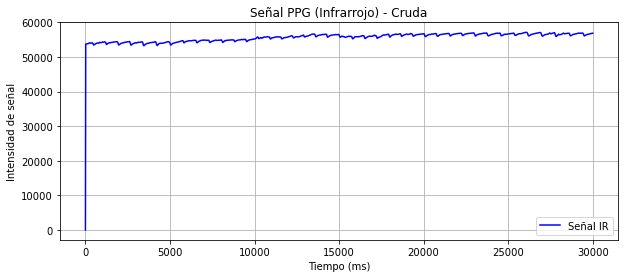

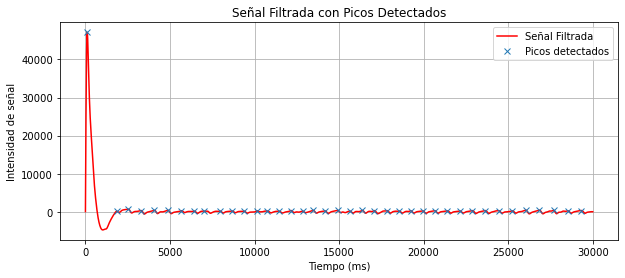

Frecuencia cardíaca estimada: 78.00 BPM


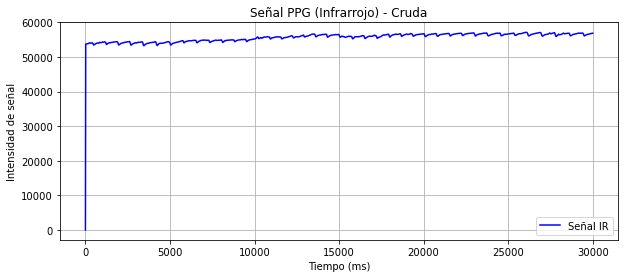

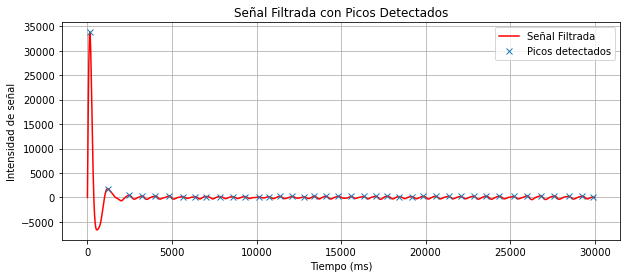

Frecuencia cardíaca estimada: 78.66 BPM


In [9]:
# Visualizar la señal PPG (IR)
plt.figure(figsize=(10, 4))
plt.plot(df["Tiempo (ms)"], df["IR"], label="Señal IR", color="blue")
plt.xlabel("Tiempo (ms)")
plt.ylabel("Intensidad de señal")
plt.title("Señal PPG (Infrarrojo) - Cruda")
plt.legend()
plt.grid(True)
plt.show()

# Filtrar la señal (Paso banda 0.8 - 2.5 Hz)
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut=0.48, highcut=4, fs=60, order=2):
    b, a = butter_bandpass(lowcut, highcut, fs, order)
    return filtfilt(b, a, data)

fs = 1000 / (df["Tiempo (ms)"].diff().mean())  # Calcular frecuencia de muestreo
df["IR_filtrada"] = bandpass_filter(df["IR"], fs=fs)

# Detectar picos con umbral dinámico
threshold = df["IR_filtrada"].median() * 1.2  # Umbral basado en la mediana de la señal filtrada
peaks, _ = find_peaks(df["IR_filtrada"], height=threshold, distance=fs/2)  # Separación mínima de 0.5s (~30 BPM)

# Graficar señal filtrada y picos detectados
plt.figure(figsize=(10, 4))
plt.plot(df["Tiempo (ms)"], df["IR_filtrada"], label="Señal Filtrada", color="red")
plt.plot(df["Tiempo (ms)"].iloc[peaks], df["IR_filtrada"].iloc[peaks], "x", label="Picos detectados")
plt.xlabel("Tiempo (ms)")
plt.ylabel("Intensidad de señal")
plt.title("Señal Filtrada con Picos Detectados")
plt.legend()
plt.grid(True)
plt.show()

# Calcular frecuencia cardíaca
rr_intervals = df["Tiempo (ms)"].iloc[peaks].diff().dropna()  # Diferencias entre picos
global_hr = 60000 / rr_intervals.mean()  # Convertir a latidos por minuto (BPM)
print(f"Frecuencia cardíaca estimada: {global_hr:.2f} BPM")


# Visualizar la señal PPG (IR)
plt.figure(figsize=(10, 4))
plt.plot(df["Tiempo (ms)"], df["IR"], label="Señal IR", color="blue")
plt.xlabel("Tiempo (ms)")
plt.ylabel("Intensidad de señal")
plt.title("Señal PPG (Infrarrojo) - Cruda")
plt.legend()
plt.grid(True)
plt.show()

# Filtrar la señal (Paso banda 0.8 - 2.5 Hz)
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut=0.8, highcut=2.5, fs=60, order=2):
    b, a = butter_bandpass(lowcut, highcut, fs, order)
    return filtfilt(b, a, data)

fs = 1000 / (df["Tiempo (ms)"].diff().mean())  # Calcular frecuencia de muestreo
df["IR_filtrada"] = bandpass_filter(df["IR"], fs=fs)

# Detectar picos con umbral dinámico
threshold = df["IR_filtrada"].median() * 1.2  # Umbral basado en la mediana de la señal filtrada
peaks, _ = find_peaks(df["IR_filtrada"], height=threshold, distance=fs/2)  # Separación mínima de 0.5s (~30 BPM)

# Graficar señal filtrada y picos detectados
plt.figure(figsize=(10, 4))
plt.plot(df["Tiempo (ms)"], df["IR_filtrada"], label="Señal Filtrada", color="red")
plt.plot(df["Tiempo (ms)"].iloc[peaks], df["IR_filtrada"].iloc[peaks], "x", label="Picos detectados")
plt.xlabel("Tiempo (ms)")
plt.ylabel("Intensidad de señal")
plt.title("Señal Filtrada con Picos Detectados")
plt.legend()
plt.grid(True)
plt.show()

# Calcular frecuencia cardíaca
rr_intervals = df["Tiempo (ms)"].iloc[peaks].diff().dropna()  # Diferencias entre picos
global_hr = 60000 / rr_intervals.mean()  # Convertir a latidos por minuto (BPM)
print(f"Frecuencia cardíaca estimada: {global_hr:.2f} BPM")


# Filtro de Savitzky-Golay
El filtro Savitzky-Golay es un filtro de suavizado polinómico que preserva las características de la señal, especialmente los picos, mientras reduce el ruido. En el código, se usa para suavizar la señal PPG (IR) antes de detectar los picos. Este filtro es útil cuando se quiere suavizar la señal sin perder las variaciones rápidas, como los latidos del corazón, lo cual es importante para las aplicaciones de monitorización de la frecuencia cardíaca.

El artículo menciona que uno de los desafíos en la medición de la frecuencia cardíaca es eliminar el ruido y las variaciones lentas de la señal, especialmente debido a artefactos de movimiento y fluctuaciones de la luz ambiente. El filtro Savitzky-Golay ayuda a reducir ese ruido, como el mencionado en la sección sobre post procesamiento y cancelación de artefactos​

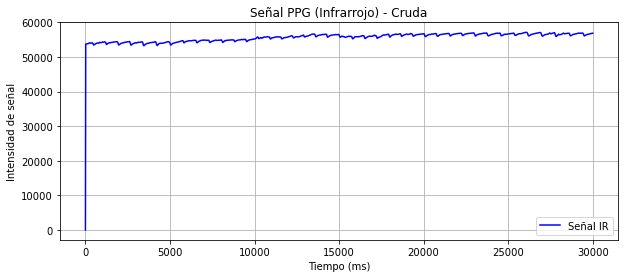

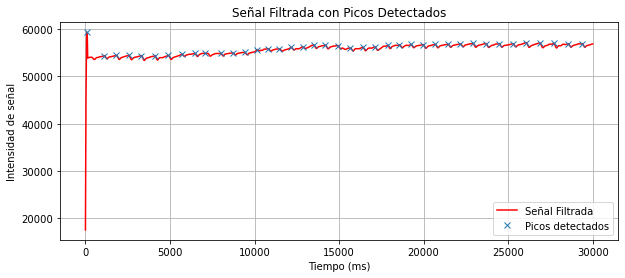

Frecuencia cardíaca estimada: 79.91 BPM


In [14]:
from scipy.signal import savgol_filter, find_peaks

# Cargar los datos
file_path = file_path = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\save_log2\raw_data_95_77_2.csv"
df = pd.read_csv(file_path)

# Visualizar la señal PPG (IR)
plt.figure(figsize=(10, 4))
plt.plot(df["Tiempo (ms)"], df["IR"], label="Señal IR", color="blue")
plt.xlabel("Tiempo (ms)")
plt.ylabel("Intensidad de señal")
plt.title("Señal PPG (Infrarrojo) - Cruda")
plt.legend()
plt.grid(True)
plt.show()

# Calcular frecuencia de muestreo (fs)
fs = 1000 / df["Tiempo (ms)"].diff().mean()  # Convertir de ms a Hz

# Aplicar filtro Savitzky-Golay (ventana de 15 muestras, polinomio de orden 3)
df["IR_filtrada"] = savgol_filter(df["IR"], window_length=15, polyorder=3)

#  Detectar picos con umbral dinámico
threshold = df["IR_filtrada"].median() * 1.1  # Umbral inicial
peaks, _ = find_peaks(df["IR_filtrada"], height=threshold, distance=fs/2)

# Si no se detectan picos, ajustar el umbral dinámicamente
if len(peaks) == 0:
    threshold = df["IR_filtrada"].median() * 0.9  # Reducir umbral
    peaks, _ = find_peaks(df["IR_filtrada"], height=threshold, distance=fs/2)

# Graficar señal filtrada y picos detectados
plt.figure(figsize=(10, 4))
plt.plot(df["Tiempo (ms)"], df["IR_filtrada"], label="Señal Filtrada", color="red")
plt.plot(df["Tiempo (ms)"].iloc[peaks], df["IR_filtrada"].iloc[peaks], "x", label="Picos detectados")
plt.xlabel("Tiempo (ms)")
plt.ylabel("Intensidad de señal")
plt.title("Señal Filtrada con Picos Detectados")
plt.legend()
plt.grid(True)
plt.show()

#  Calcular frecuencia cardíaca solo si hay picos detectados
if len(peaks) > 1:
    rr_intervals = df["Tiempo (ms)"].iloc[peaks].diff().dropna()  # Diferencias entre picos
    global_hr = 60000 / rr_intervals.mean()  # Convertir a latidos por minuto (BPM)
    print(f"Frecuencia cardíaca estimada: {global_hr:.2f} BPM")
else:
    print("No se detectaron suficientes picos para calcular la frecuencia cardíaca.")


Con este filtro, el valor es también cercano al de referencia.

A continuación, se emplea una segunda versión del análisis que optimiza varios aspectos clave respecto al enfoque anterior. Se incrementa ligeramente el tamaño de la ventana del filtro Savitzky-Golay para mejorar la suavidad de la señal y se ajusta el orden del polinomio para evitar sobreajustes. Además, el umbral de detección de picos se define ahora de forma adaptativa a partir de la media y la desviación estándar. Para mejorar la fiabilidad del cálculo de la frecuencia cardíaca, también se introducen medidas de control de calidad: si se detectan pocos picos, se reduce el umbral, y tras detectar los picos, se eliminan intervalos anómalos (muy largos o muy cortos) antes de calcular la frecuencia final a partir de la mediana, lo que reduce la influencia de posibles errores puntuales.

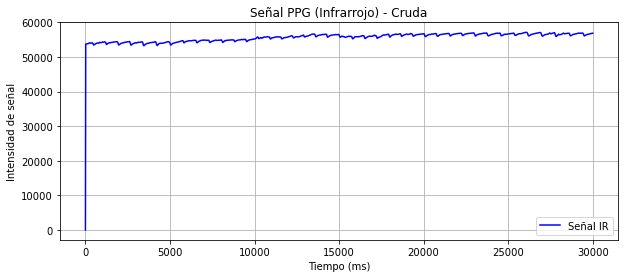

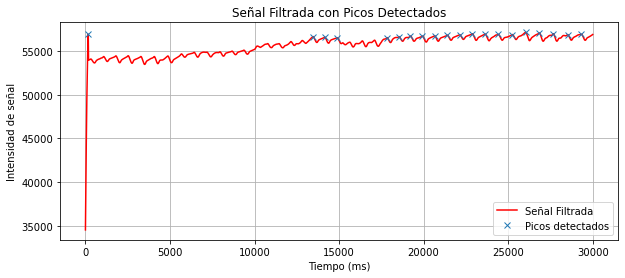

Frecuencia cardíaca estimada: 80.00 BPM


In [16]:
# Visualizar la señal PPG (IR)
plt.figure(figsize=(10, 4))
plt.plot(df["Tiempo (ms)"], df["IR"], label="Señal IR", color="blue")
plt.xlabel("Tiempo (ms)")
plt.ylabel("Intensidad de señal")
plt.title("Señal PPG (Infrarrojo) - Cruda")
plt.legend()
plt.grid(True)
plt.show()

# Calcular frecuencia de muestreo (fs)
fs = 1000 / df["Tiempo (ms)"].diff().mean()  # Convertir de ms a Hz

# Aplicar filtro Savitzky-Golay (ventana de 21 muestras, polinomio de orden 2)
df["IR_filtrada"] = savgol_filter(df["IR"], window_length=21, polyorder=2)

# Detectar picos con umbral dinámico optimizado
threshold = df["IR_filtrada"].mean() + 0.6 * df["IR_filtrada"].std()  # Umbral basado en la media y desviación estándar
peaks, _ = find_peaks(df["IR_filtrada"], height=threshold, distance=fs/2.2)  # Ajuste fino del parámetro distance

# Si no se detectan suficientes picos, reducir el umbral
if len(peaks) < 3:
    threshold = df["IR_filtrada"].mean() + 0.4 * df["IR_filtrada"].std()
    peaks, _ = find_peaks(df["IR_filtrada"], height=threshold, distance=fs/2.2)

# Graficar señal filtrada y picos detectados
plt.figure(figsize=(10, 4))
plt.plot(df["Tiempo (ms)"], df["IR_filtrada"], label="Señal Filtrada", color="red")
plt.plot(df["Tiempo (ms)"].iloc[peaks], df["IR_filtrada"].iloc[peaks], "x", label="Picos detectados")
plt.xlabel("Tiempo (ms)")
plt.ylabel("Intensidad de señal")
plt.title("Señal Filtrada con Picos Detectados")
plt.legend()
plt.grid(True)
plt.show()

# Calcular frecuencia cardíaca con eliminación de valores extremos
if len(peaks) > 1:
    rr_intervals = df["Tiempo (ms)"].iloc[peaks].diff().dropna()
    rr_intervals = rr_intervals[(rr_intervals > rr_intervals.quantile(0.1)) & (rr_intervals < rr_intervals.quantile(0.9))]  # Filtrar valores extremos
    global_hr = 60000 / rr_intervals.median()  # Usar mediana en lugar de media para mayor precisión
    print(f"Frecuencia cardíaca estimada: {global_hr:.2f} BPM")
else:
    print("No se detectaron suficientes picos para calcular la frecuencia cardíaca.")


Ahora pruebo esto mismo pero con todos los registros

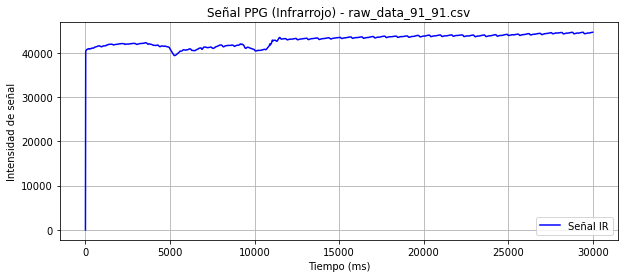

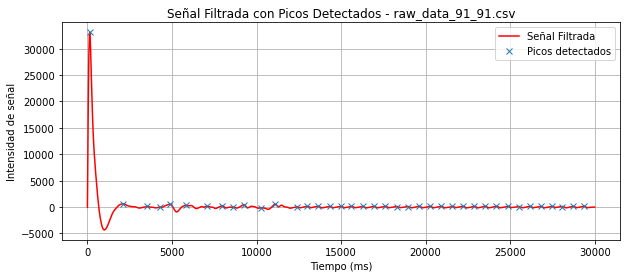

Frecuencia cardíaca estimada para raw_data_91_91.csv: 78.04 bpm


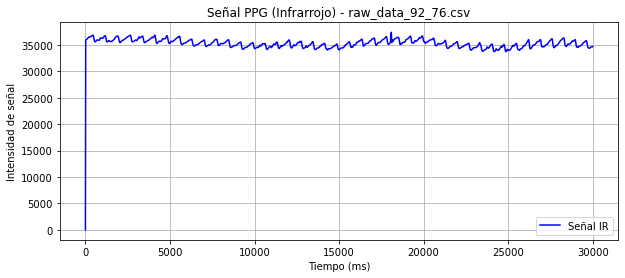

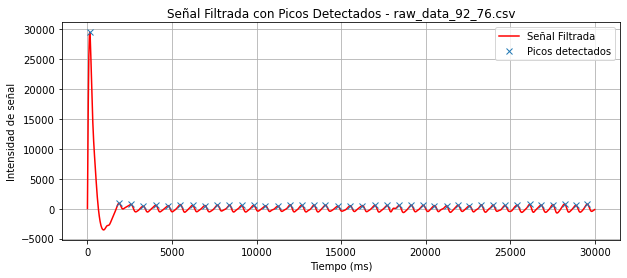

Frecuencia cardíaca estimada para raw_data_92_76.csv: 81.55 bpm


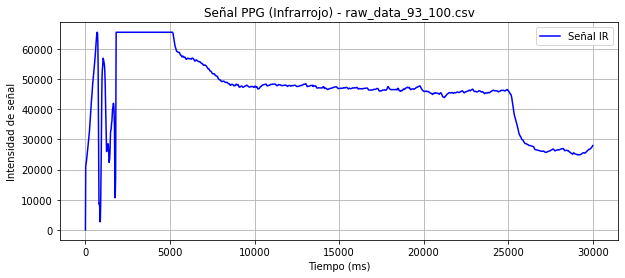

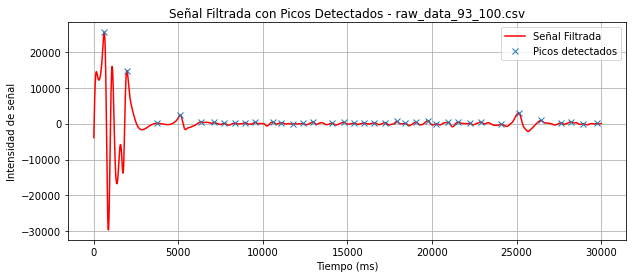

Frecuencia cardíaca estimada para raw_data_93_100.csv: 74.19 bpm


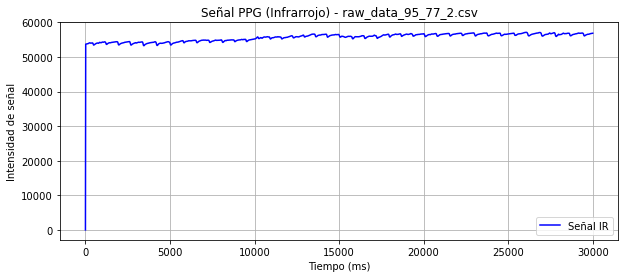

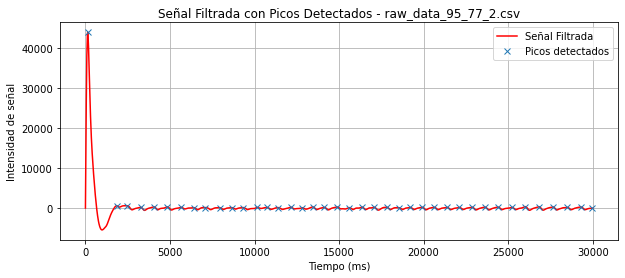

Frecuencia cardíaca estimada para raw_data_95_77_2.csv: 78.49 bpm


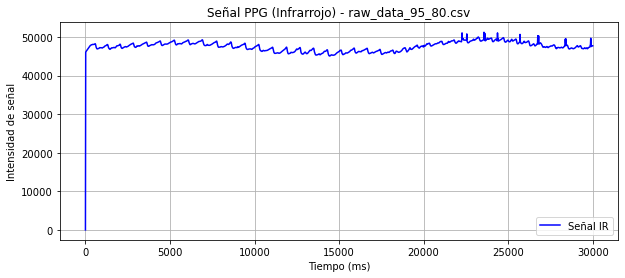

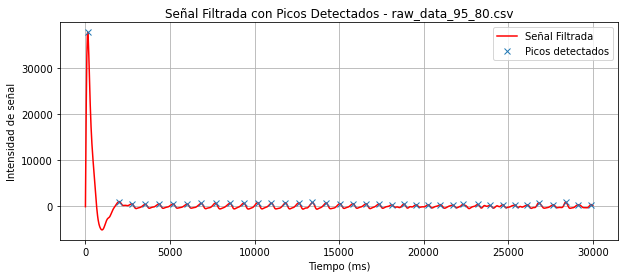

Frecuencia cardíaca estimada para raw_data_95_80.csv: 74.59 bpm


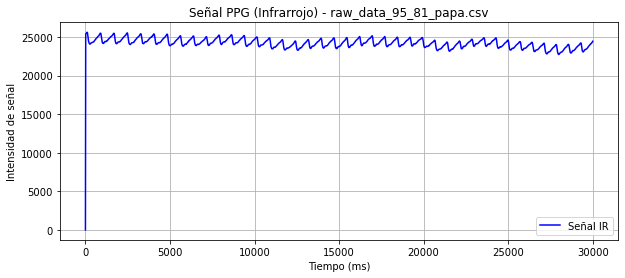

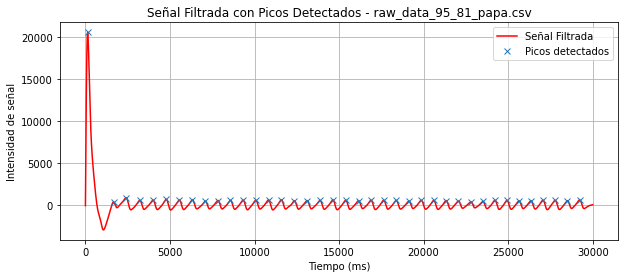

Frecuencia cardíaca estimada para raw_data_95_81_papa.csv: 78.36 bpm


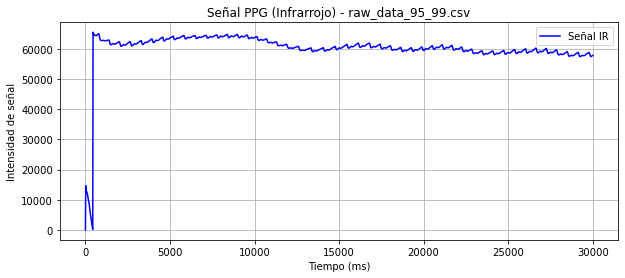

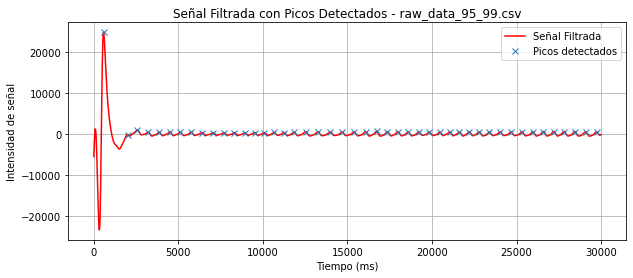

Frecuencia cardíaca estimada para raw_data_95_99.csv: 92.63 bpm


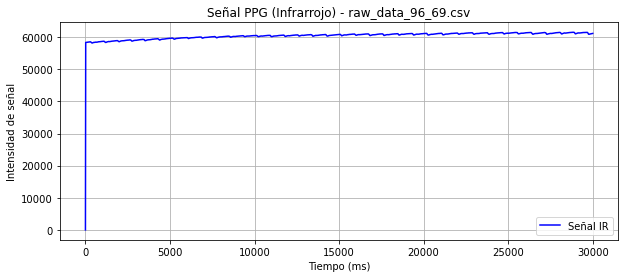

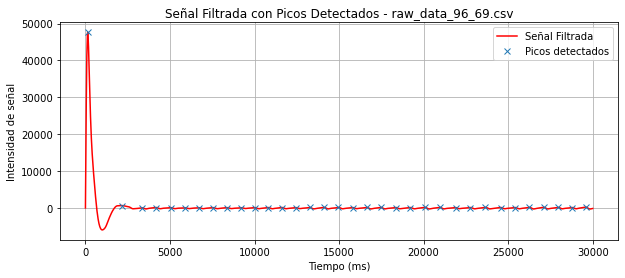

Frecuencia cardíaca estimada para raw_data_96_69.csv: 67.24 bpm


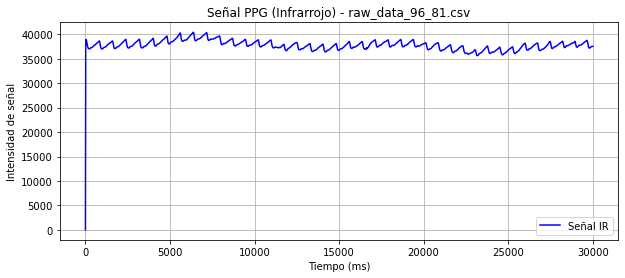

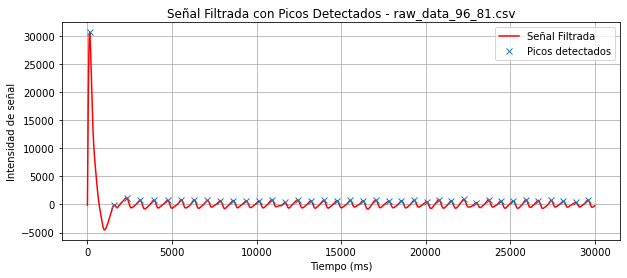

Frecuencia cardíaca estimada para raw_data_96_81.csv: 77.38 bpm


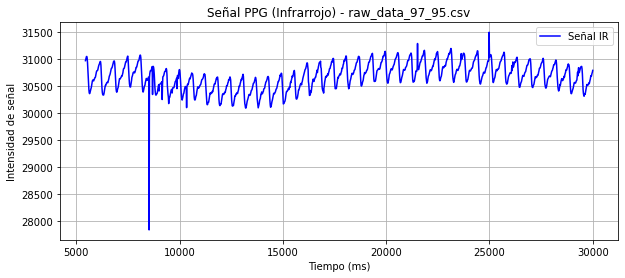

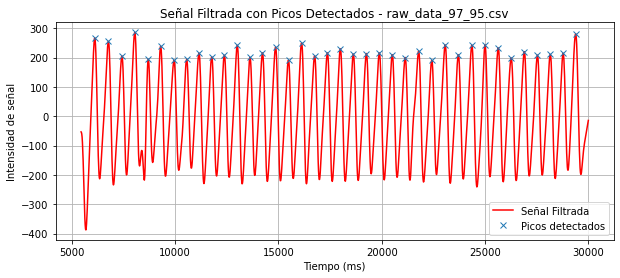

Frecuencia cardíaca estimada para raw_data_97_95.csv: 95.41 bpm


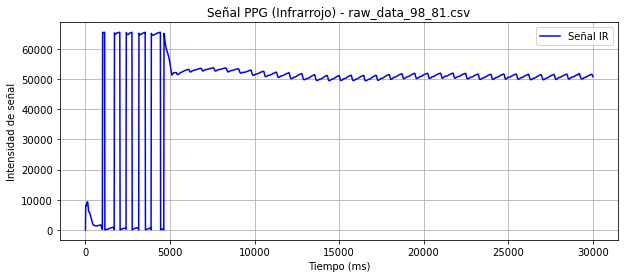

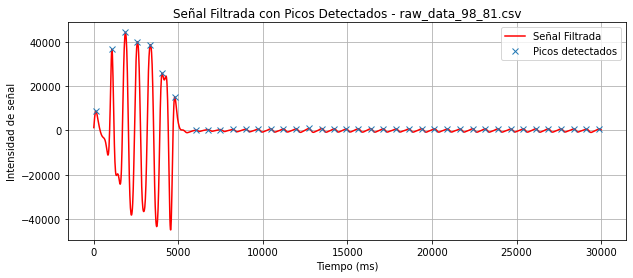

Frecuencia cardíaca estimada para raw_data_98_81.csv: 78.62 bpm


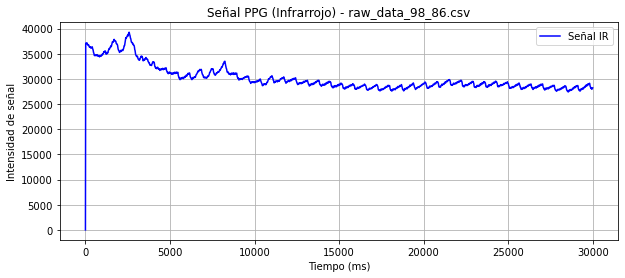

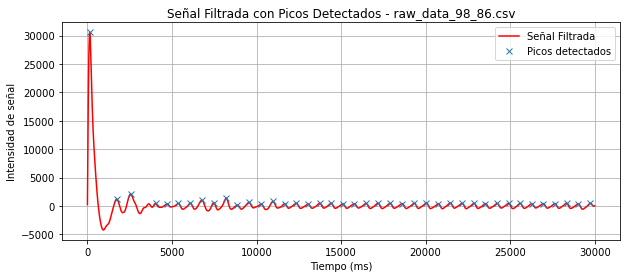

Frecuencia cardíaca estimada para raw_data_98_86.csv: 81.04 bpm


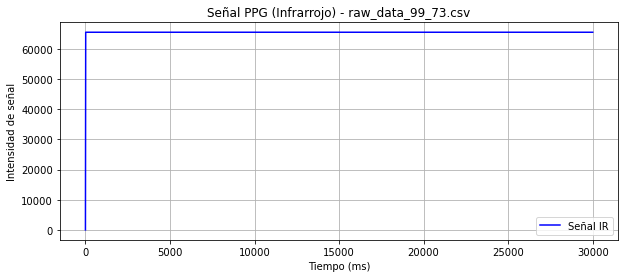

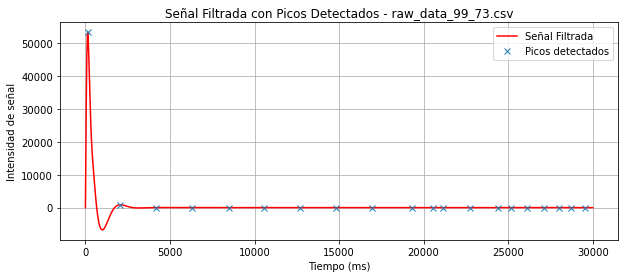

Frecuencia cardíaca estimada para raw_data_99_73.csv: 38.78 bpm


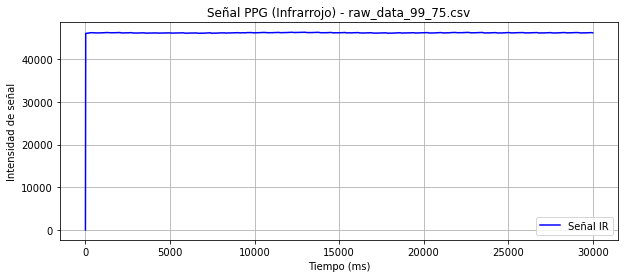

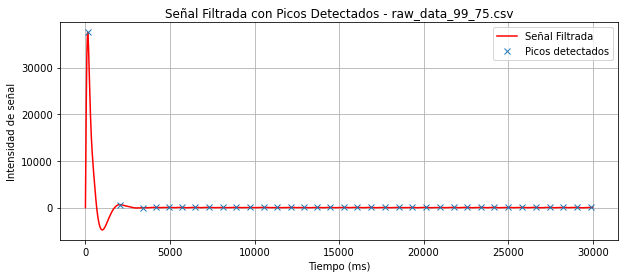

Frecuencia cardíaca estimada para raw_data_99_75.csv: 70.59 bpm


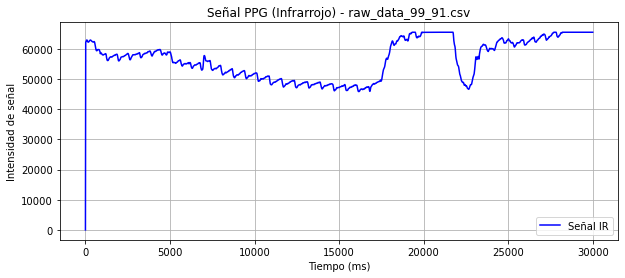

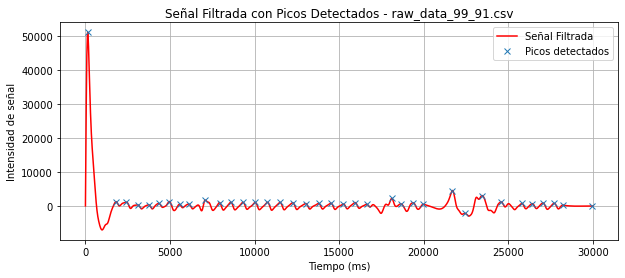

Frecuencia cardíaca estimada para raw_data_99_91.csv: 72.45 bpm


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks
import os

# 1. Definir la carpeta con los archivos CSV
folder_path = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\save_log2"

# 2. Funciones de filtrado (Butterworth)
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut=0.5, highcut=3.0, fs=60, order=2):
    b, a = butter_bandpass(lowcut, highcut, fs, order)
    return filtfilt(b, a, data)

# 3. Procesar cada archivo CSV en la carpeta
for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):  # Asegurarse de que es un archivo CSV
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)

        # 4. Visualizar la señal PPG (IR)
        plt.figure(figsize=(10, 4))
        plt.plot(df["Tiempo (ms)"], df["IR"], label="Señal IR", color="blue")
        plt.xlabel("Tiempo (ms)")
        plt.ylabel("Intensidad de señal")
        plt.title(f"Señal PPG (Infrarrojo) - {filename}")
        plt.legend()
        plt.grid(True)
        plt.show()

        # 5. Filtrar la señal
        fs = 1000 / df["Tiempo (ms)"].diff().mean()  # Calcular frecuencia de muestreo
        df["IR_filtrada"] = bandpass_filter(df["IR"], fs=fs)

        # 6. Detectar picos para calcular la frecuencia cardíaca
        peaks, _ = find_peaks(df["IR_filtrada"], distance=fs/2)  # Separación mínima de 0.5s (~30 latidos/min)

        # Graficar señal filtrada y picos detectados
        plt.figure(figsize=(10, 4))
        plt.plot(df["Tiempo (ms)"], df["IR_filtrada"], label="Señal Filtrada", color="red")
        plt.plot(df["Tiempo (ms)"].iloc[peaks], df["IR_filtrada"].iloc[peaks], "x", label="Picos detectados")
        plt.xlabel("Tiempo (ms)")
        plt.ylabel("Intensidad de señal")
        plt.title(f"Señal Filtrada con Picos Detectados - {filename}")
        plt.legend()
        plt.grid(True)
        plt.show()

        # 7. Calcular frecuencia cardíaca
        rr_intervals = df["Tiempo (ms)"].iloc[peaks].diff().dropna()  # Diferencias entre picos
        global_hr = 60000 / rr_intervals.mean()  # Convertir a latidos por minuto (bpm)
        print(f"Frecuencia cardíaca estimada para {filename}: {global_hr:.2f} bpm")


Aunque hay algunas señales que no son del todo buenas, los resultados en aquellas que están claras tampoco están tan mal.

Voy a probar con alguna de forma individual

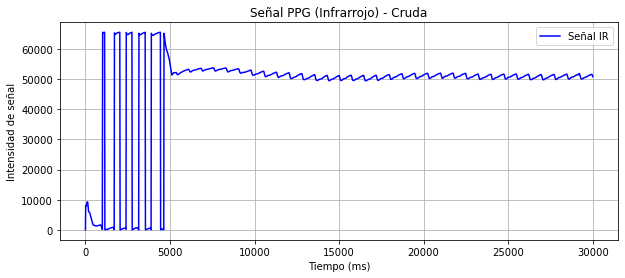

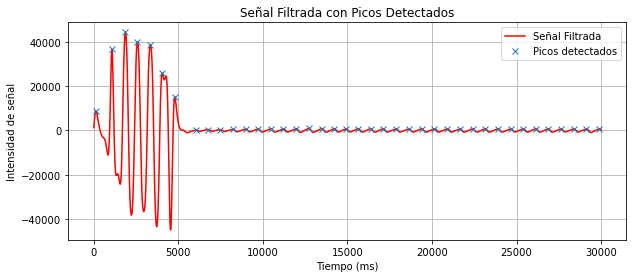

Frecuencia cardíaca estimada: 78.62 bpm


In [21]:

# 1. Cargar los datos
file_path = file_path = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\save_log2\raw_data_98_81.csv"
df = pd.read_csv(file_path)

# 2. Visualizar la señal PPG (IR)
plt.figure(figsize=(10, 4))
plt.plot(df["Tiempo (ms)"], df["IR"], label="Señal IR", color="blue")
plt.xlabel("Tiempo (ms)")
plt.ylabel("Intensidad de señal")
plt.title("Señal PPG (Infrarrojo) - Cruda")
plt.legend()
plt.grid(True)
plt.show()

# 3. Filtrar la señal (Paso banda 0.5 - 3 Hz)
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut=0.5, highcut=3.0, fs=60, order=2):
    b, a = butter_bandpass(lowcut, highcut, fs, order)
    return filtfilt(b, a, data)

fs = 1000 / (df["Tiempo (ms)"].diff().mean())  # Calcular frecuencia de muestreo
df["IR_filtrada"] = bandpass_filter(df["IR"], fs=fs)

# 4. Detectar picos para calcular la frecuencia cardíaca
peaks, _ = find_peaks(df["IR_filtrada"], distance=fs/2)  # Separación mínima de 0.5s (~30 latidos/min)

# Graficar señal filtrada y picos detectados
plt.figure(figsize=(10, 4))
plt.plot(df["Tiempo (ms)"], df["IR_filtrada"], label="Señal Filtrada", color="red")
plt.plot(df["Tiempo (ms)"].iloc[peaks], df["IR_filtrada"].iloc[peaks], "x", label="Picos detectados")
plt.xlabel("Tiempo (ms)")
plt.ylabel("Intensidad de señal")
plt.title("Señal Filtrada con Picos Detectados")
plt.legend()
plt.grid(True)
plt.show()

# 5. Calcular frecuencia cardíaca
rr_intervals = df["Tiempo (ms)"].iloc[peaks].diff().dropna()  # Diferencias entre picos
global_hr = 60000 / rr_intervals.mean()  # Convertir a latidos por minuto (bpm)
print(f"Frecuencia cardíaca estimada: {global_hr:.2f} bpm")


In [ ]:
Claramente en esta señal habría que recortar los primeros 5 segundos, asi que vamos a ello

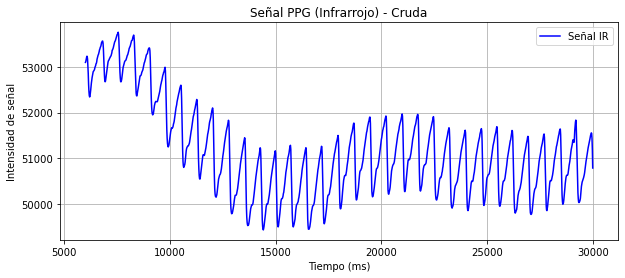

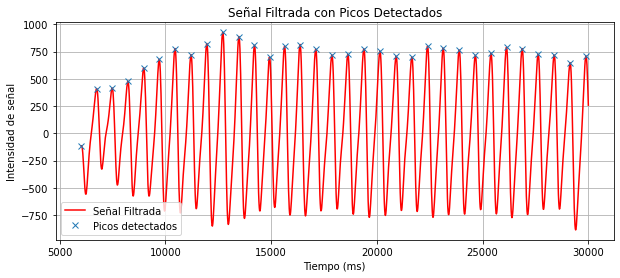

Frecuencia cardíaca estimada: 80.50 bpm


In [24]:

# Eliminar los primeros 5000 ms
df = df[df["Tiempo (ms)"] >= 5500].reset_index(drop=True)

# Visualizar la señal PPG (IR)
plt.figure(figsize=(10, 4))
plt.plot(df["Tiempo (ms)"], df["IR"], label="Señal IR", color="blue")
plt.xlabel("Tiempo (ms)")
plt.ylabel("Intensidad de señal")
plt.title("Señal PPG (Infrarrojo) - Cruda")
plt.legend()
plt.grid(True)
plt.show()

# Filtrar la señal (Paso banda 0.5 - 3 Hz)
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut=0.5, highcut=3.0, fs=60, order=2):
    b, a = butter_bandpass(lowcut, highcut, fs, order)
    return filtfilt(b, a, data)

fs = 1000 / (df["Tiempo (ms)"].diff().mean())  # Calcular frecuencia de muestreo
df["IR_filtrada"] = bandpass_filter(df["IR"], fs=fs)

#  Detectar picos para calcular la frecuencia cardíaca
peaks, _ = find_peaks(df["IR_filtrada"], distance=fs/2)  # Separación mínima de 0.5s (~30 latidos/min)

# Graficar señal filtrada y picos detectados
plt.figure(figsize=(10, 4))
plt.plot(df["Tiempo (ms)"], df["IR_filtrada"], label="Señal Filtrada", color="red")
plt.plot(df["Tiempo (ms)"].iloc[peaks], df["IR_filtrada"].iloc[peaks], "x", label="Picos detectados")
plt.xlabel("Tiempo (ms)")
plt.ylabel("Intensidad de señal")
plt.title("Señal Filtrada con Picos Detectados")
plt.legend()
plt.grid(True)
plt.show()

# 5. Calcular frecuencia cardíaca
rr_intervals = df["Tiempo (ms)"].iloc[peaks].diff().dropna()  # Diferencias entre picos
global_hr = 60000 / rr_intervals.mean()  # Convertir a latidos por minuto (bpm)
print(f"Frecuencia cardíaca estimada: {global_hr:.2f} bpm")


Este método da muy buenos resultados cuando nos quedamos con la parte válida de la señal. Lo tenemos en cuenta.

Vamos a probar con un recorte específico de cada señal:

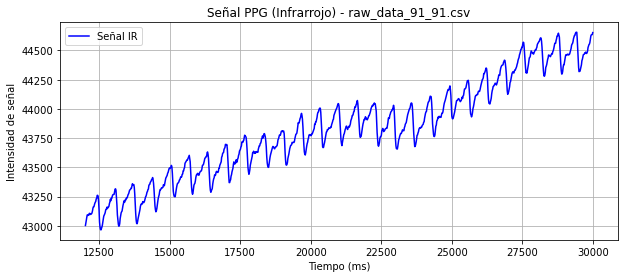

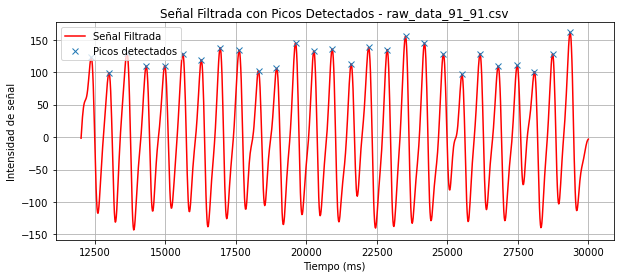

Frecuencia cardíaca estimada para raw_data_91_91.csv: 91.91 bpm


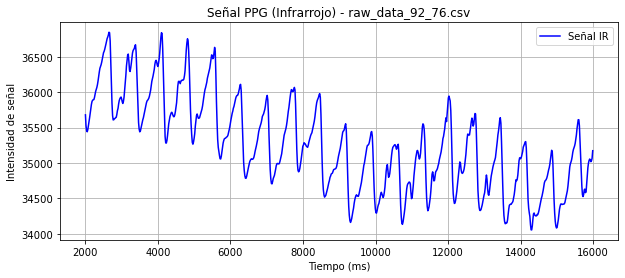

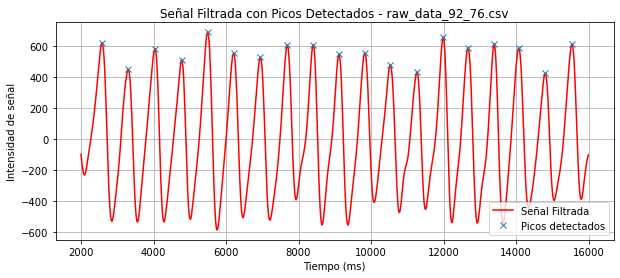

Frecuencia cardíaca estimada para raw_data_92_76.csv: 83.35 bpm


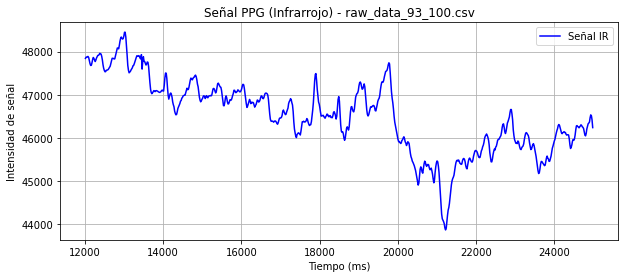

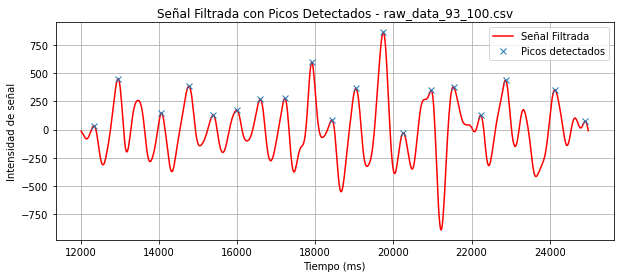

Frecuencia cardíaca estimada para raw_data_93_100.csv: 85.99 bpm


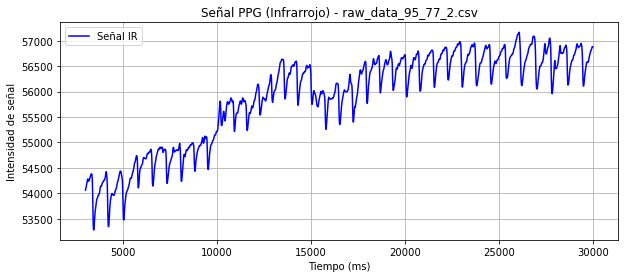

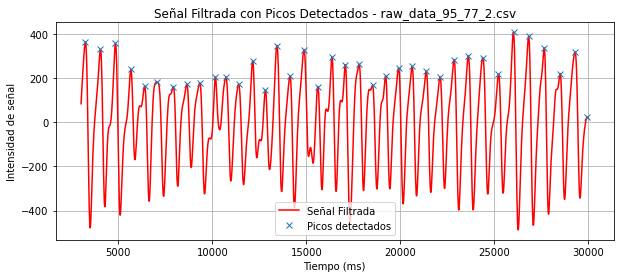

Frecuencia cardíaca estimada para raw_data_95_77_2.csv: 80.90 bpm


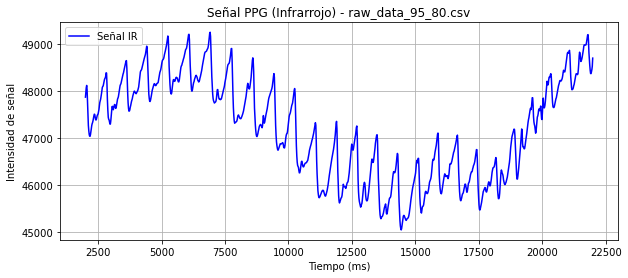

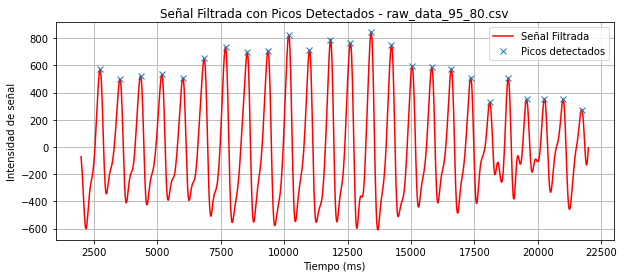

Frecuencia cardíaca estimada para raw_data_95_80.csv: 75.91 bpm


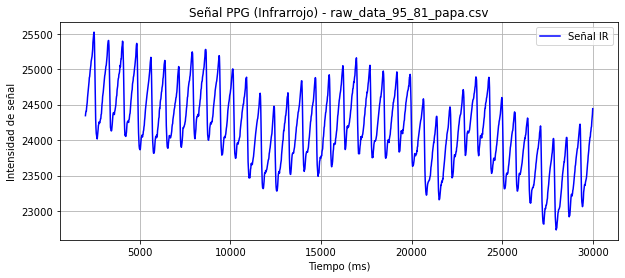

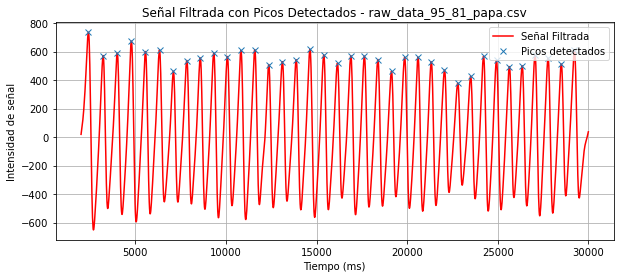

Frecuencia cardíaca estimada para raw_data_95_81_papa.csv: 80.50 bpm


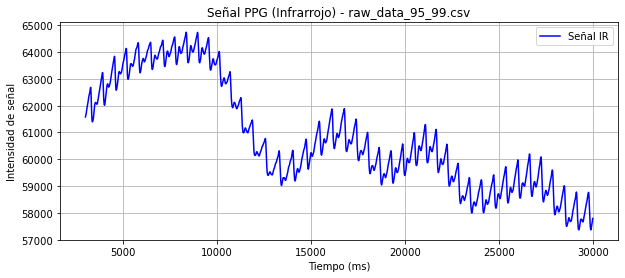

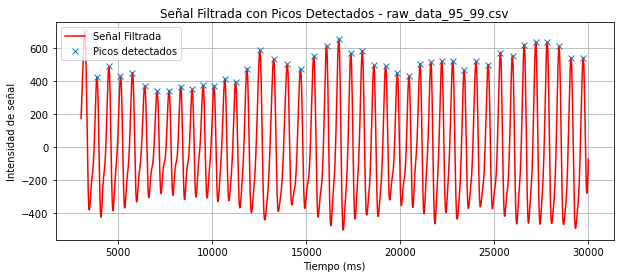

Frecuencia cardíaca estimada para raw_data_95_99.csv: 95.04 bpm


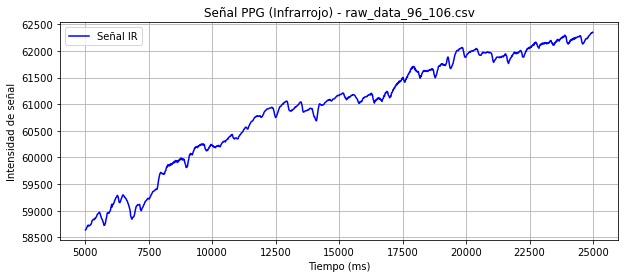

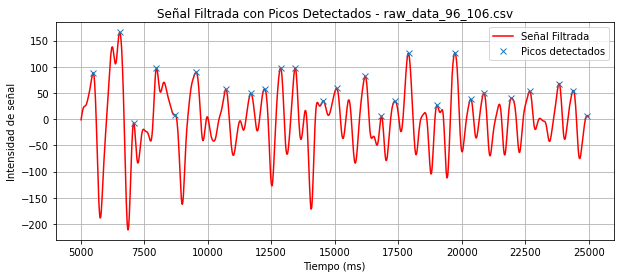

Frecuencia cardíaca estimada para raw_data_96_106.csv: 77.17 bpm


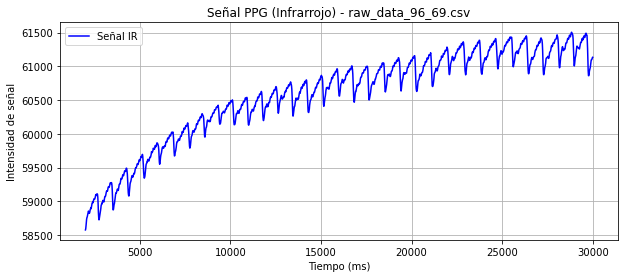

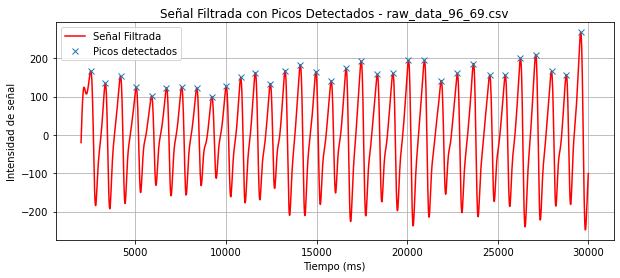

Frecuencia cardíaca estimada para raw_data_96_69.csv: 70.98 bpm


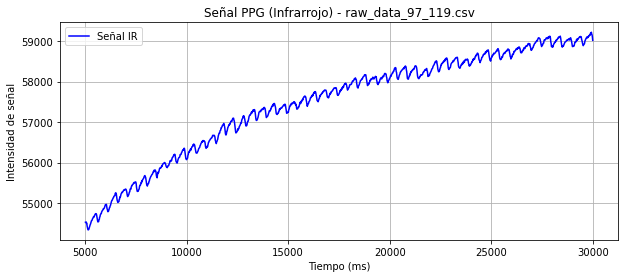

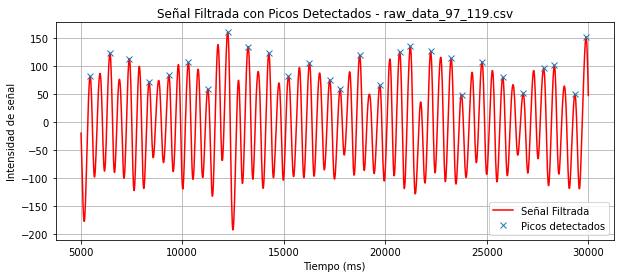

Frecuencia cardíaca estimada para raw_data_97_119.csv: 66.34 bpm


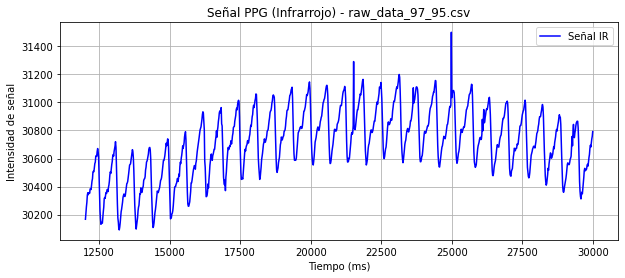

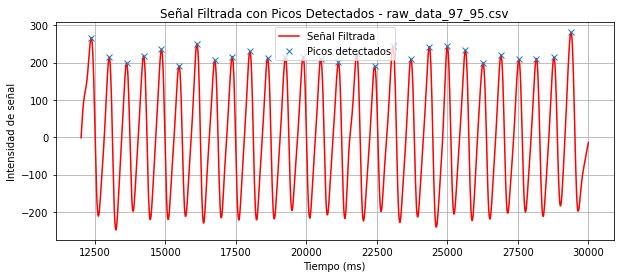

Frecuencia cardíaca estimada para raw_data_97_95.csv: 95.25 bpm


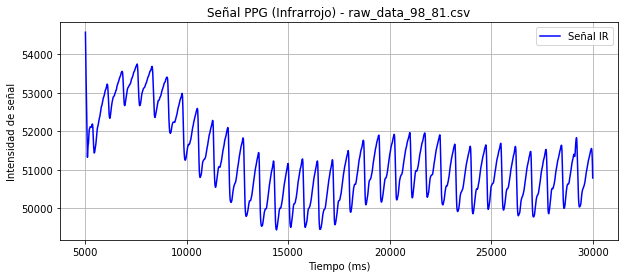

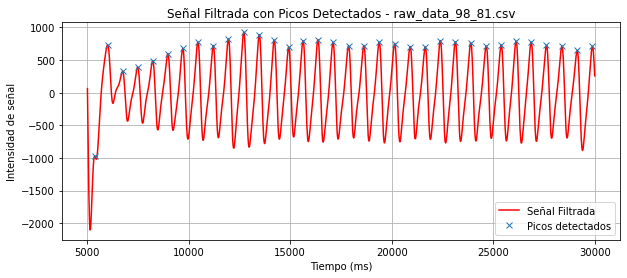

Frecuencia cardíaca estimada para raw_data_98_81.csv: 80.76 bpm


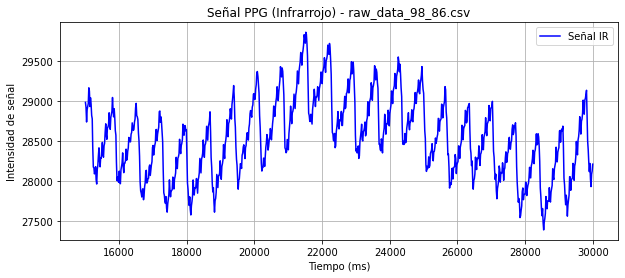

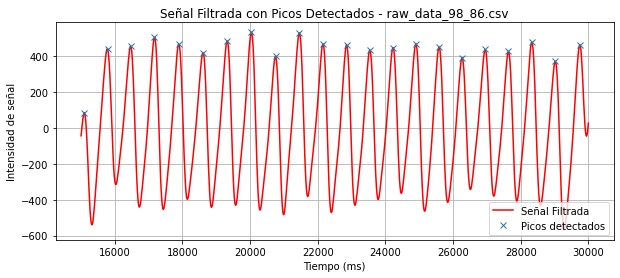

Frecuencia cardíaca estimada para raw_data_98_86.csv: 86.07 bpm


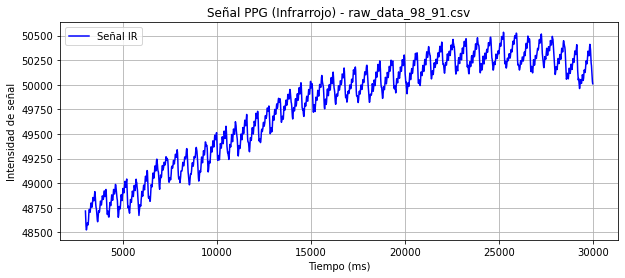

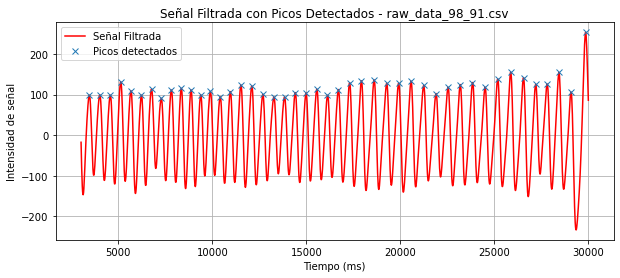

Frecuencia cardíaca estimada para raw_data_98_91.csv: 100.00 bpm


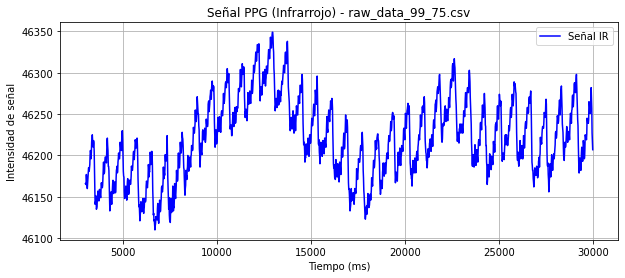

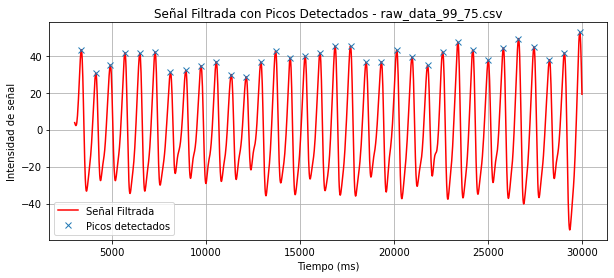

Frecuencia cardíaca estimada para raw_data_99_75.csv: 74.67 bpm


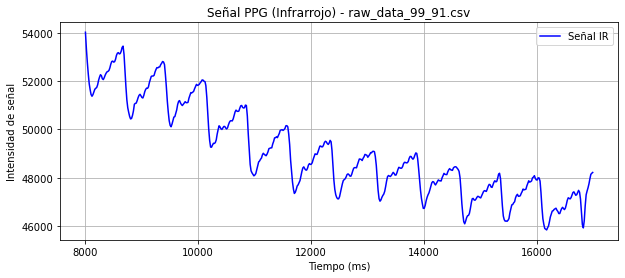

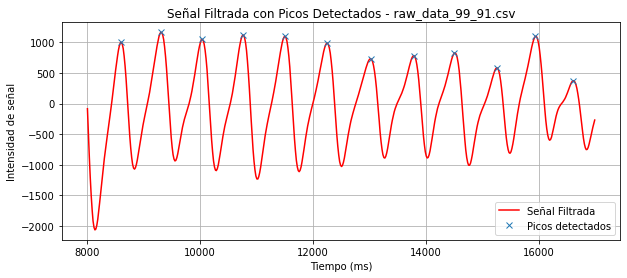

Frecuencia cardíaca estimada para raw_data_99_91.csv: 82.55 bpm


In [2]:

import os

# 1. Definir la carpeta con los archivos CSV
folder_path = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos_limpios"

# 2. Funciones de filtrado (Butterworth)
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut=0.5, highcut=3.0, fs=60, order=2):
    b, a = butter_bandpass(lowcut, highcut, fs, order)
    return filtfilt(b, a, data)

# 3. Procesar cada archivo CSV en la carpeta
for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):  # Asegurarse de que es un archivo CSV
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)

        # 4. Visualizar la señal PPG (IR)
        plt.figure(figsize=(10, 4))
        plt.plot(df["Tiempo (ms)"], df["IR"], label="Señal IR", color="blue")
        plt.xlabel("Tiempo (ms)")
        plt.ylabel("Intensidad de señal")
        plt.title(f"Señal PPG (Infrarrojo) - {filename}")
        plt.legend()
        plt.grid(True)
        plt.show()

        # 5. Filtrar la señal
        fs = 1000 / df["Tiempo (ms)"].diff().mean()  # Calcular frecuencia de muestreo
        df["IR_filtrada"] = bandpass_filter(df["IR"], fs=fs)

        # 6. Detectar picos para calcular la frecuencia cardíaca
        peaks, _ = find_peaks(df["IR_filtrada"], distance=fs/2)  # Separación mínima de 0.5s (~30 latidos/min)

        # Graficar señal filtrada y picos detectados
        plt.figure(figsize=(10, 4))
        plt.plot(df["Tiempo (ms)"], df["IR_filtrada"], label="Señal Filtrada", color="red")
        plt.plot(df["Tiempo (ms)"].iloc[peaks], df["IR_filtrada"].iloc[peaks], "x", label="Picos detectados")
        plt.xlabel("Tiempo (ms)")
        plt.ylabel("Intensidad de señal")
        plt.title(f"Señal Filtrada con Picos Detectados - {filename}")
        plt.legend()
        plt.grid(True)
        plt.show()

        # 7. Calcular frecuencia cardíaca
        rr_intervals = df["Tiempo (ms)"].iloc[peaks].diff().dropna()  # Diferencias entre picos
        global_hr = 60000 / rr_intervals.mean()  # Convertir a latidos por minuto (bpm)
        print(f"Frecuencia cardíaca estimada para {filename}: {global_hr:.2f} bpm")


Depende mucho de la señal, por ejemplo en este ultimo caso, no es valido. No obstante es un codigo válido para luego pasar al firmware.

# Resumen de los resultados

In [1]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks

# Ruta de tus archivos CSV
folder_path = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos_limpios"
resultados = []

# Funciones de filtrado
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    return butter(order, [low, high], btype='band')

def bandpass_filter(data, lowcut=0.5, highcut=3.0, fs=60, order=2):
    b, a = butter_bandpass(lowcut, highcut, fs, order)
    return filtfilt(b, a, data)

# Procesar cada archivo
for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        filepath = os.path.join(folder_path, filename)
        df = pd.read_csv(filepath)

        # FC esperada desde el nombre del archivo
        match = re.match(r".*_(\d+)_(\d+)", filename)
        expected_hr = int(match.group(2)) if match else None

        # Calcular frecuencia de muestreo
        fs = 1000 / df["Tiempo (ms)"].diff().mean()

        # Filtrar señal y detectar picos
        df["IR_filtrada"] = bandpass_filter(df["IR"], fs=fs)
        peaks, _ = find_peaks(df["IR_filtrada"], distance=fs/2)
        rr_intervals = df["Tiempo (ms)"].iloc[peaks].diff().dropna()
        estimated_hr = 60000 / rr_intervals.mean() if not rr_intervals.empty else None

        # Guardar resultado
        resultados.append({
            "Archivo": filename,
            "FC esperada (bpm)": expected_hr,
            "FC calculada (bpm)": round(estimated_hr, 2) if estimated_hr else "Error"
        })

# Crear tabla final
tabla = pd.DataFrame(resultados)
print(tabla)

#  GUARDAR COMO CSV
csv_output = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Código\resultados_fc.csv"
tabla.to_csv(csv_output, index=False)

# GUARDAR COMO IMAGEN
fig, ax = plt.subplots(figsize=(10, len(tabla) * 0.5 + 1))
ax.axis('off')
tabla_img = ax.table(cellText=tabla.values,
                     colLabels=tabla.columns,
                     cellLoc='center',
                     loc='center')
tabla_img.auto_set_font_size(False)
tabla_img.set_fontsize(10)
tabla_img.scale(1, 1.5)

png_output = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Código\resultados_fc.png"
plt.savefig(png_output, bbox_inches='tight', dpi=300)
plt.close()


                    Archivo  FC esperada (bpm)  FC calculada (bpm)
0        raw_data_91_91.csv                 91               91.91
1        raw_data_92_76.csv                 76               83.35
2       raw_data_93_100.csv                100               85.99
3      raw_data_95_77_2.csv                  2               80.90
4        raw_data_95_80.csv                 80               75.91
5   raw_data_95_81_papa.csv                 81               80.50
6        raw_data_95_99.csv                 99               95.04
7       raw_data_96_106.csv                106               77.17
8        raw_data_96_69.csv                 69               70.98
9       raw_data_97_119.csv                119               66.34
10       raw_data_97_95.csv                 95               95.25
11       raw_data_98_81.csv                 81               80.76
12       raw_data_98_86.csv                 86               86.07
13       raw_data_98_91.csv                 91              10